In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from random import sample

### Import BOW document vectors

In [3]:
#BOW = pickle.load(open("../processing_files/bow.pickle", "rb"))
#BOW = np.load("../../processed_files/bow/bow_matrix.npy")
#BOW = scipy.sparse.load_npz('../../processed_files/bow/bow_matrix.npz')
stemmed_BOW = scipy.sparse.load_npz('../../processed_files/bow/stemmed_bow_matrix.npz')

In [5]:
#stemmed_BOW = np.load("../../processed_files/bow/bow_stemmed_matrix.npy")

In [6]:
df_merged = pickle.load(open("../../processed_files/df_merged.pickle", "rb"))

In [7]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED
0,0-my.com,0-my.com related searches: related searches:,"[mycom, related, searches, related, searches]","[mycom, relat, search, relat, search]"
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[error, page, cannot, display, pleas, contact,..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailable, purchase, wwwvcom, welcome, uu...","[com, vailabl, purchas, wwwvcom, welcom, uunic..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dnsir, ir, hits, construction, coming, so...","[ir, dnsir, ir, hit, construct, come, soon, ho..."
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[februari, onlin, market, review, search, rece..."


In [8]:
df_merged.shape

(12975, 4)

In [9]:
BOW.shape

(12975, 310919)

In [ ]:
#stemmed_BOW.shape

## knn

In [ ]:
%%time
nbrs50 = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(BOW)
distances50, indices50 = nbrs50.kneighbors(BOW)

In [ ]:
%%time
stemmed_nbrs50 = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(stemmed_BOW)
stemmed_distances50, stemmed_indices50 = stemmed_nbrs50.kneighbors(stemmed_BOW)

In [ ]:
%%time
nbrs10 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(BOW)
distances10, indices10 = nbrs10.kneighbors(BOW)

In [ ]:
%%time
stemmed_nbrs10 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(stemmed_BOW)
stemmed_distances10, stemmed_indices10 = stemmed_nbrs10.kneighbors(stemmed_BOW)

In [9]:
print(distances50.shape)
print(indices50.shape)

(12949, 50)
(12949, 50)


In [10]:
print(distances10.shape)
print(distances10.shape)

(12949, 10)
(12949, 10)


In [11]:
distances50[0]

array([0.        , 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356])

In [12]:
indices50[0]

array([    0,  1693,  1992,  4087,   249,  4113,   159,   165,  9188,
        4168,  4779,  6214,  3251, 12179,  3209,  3958,  6215,  7378,
        8670,   656,  2095, 10772,  4959,  7898,  8458,  5861,  2414,
        3963,  3957,  8227,  1156, 11648,  5300, 12368, 12406,  5436,
        7403,   137,  5561,  8830,  4729,  3995,   566,  9965, 10035,
        3641,  7936,  8709,  1961, 10908])

In [13]:
import statistics

def intracluster_similarity(index, indices):
    cluster_centroid = BOW[index].toarray()
    sum_dist = 0
    dist_list = []
    for i in indices[index][1:]:
        distance = np.linalg.norm(cluster_centroid-BOW[i].toarray())
        sum_dist += distance
        dist_list.append(distance)
        #print(index, ',', i, '=', distance)
        
    avg = sum_dist/(len(indices[index])-1)
    #print('average:', avg)
    
    variance = statistics.variance(dist_list)
    #print('variance:', variance)
    
    return avg, variance

In [14]:
intracluster_similarity(0, indices50)

(1.414213562373094, 0.0)

In [18]:
def generate_raw_content_cluster_df(index, indices, distances):
    index_list = list(indices[index])
    distance_list = list(distances[index])
    cluster_seed = df_merged.loc[index].to_frame().T
    cluster_seed['DISTANCE'] = 0
    cluster_df = df_merged.loc[index_list[1:]]
    cluster_df['DISTANCE'] = distance_list[1:]
    combined = pd.concat([cluster_seed, cluster_df.sort_values(by='DISTANCE', ascending=True)])
    return combined.style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})

In [19]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic pages
generate_raw_content_cluster_df(2, indices50, distances50)

,DOMAIN,RAW_CONTENT,DISTANCE
2,01187.com,"01187.com is available for purchase! - wwwv1.com welcome to uunic.com,these domain names are for sale,feel free to contact us! filter by suffix on sale $22600 01187.com 01187.com this domain is of unlimited value. this domain is for sale - $22600 usd! inquery this domain : reach agreementreasonable price start transactionfair and safe payment sentdomain transfered both confirmedtransaction closed make offer online domain: your name: offer price: usd sorry,your offer is too low,we will never consider e-mail: inquiry: enteraccess code: * send recommended payment method easy,big amount,low fees! my bank information intermediary bank: china merchants bank co. ltd., new york. bank swift code：cmbcus33 beneficiary’s bank: china merchants bank, h.o. bank address：cmb tower,7088 shennan boulevard, shenzhen, china. bank swift code：cmbccnbs my bank account name： my bank account number： my phone number: (+86)400-601-5335 domain: your name: domain transfer by:godaddy pushauthorization code domain price: usd paypal fees: buyer pay50% eachseller pay payment detail: paypal fees:,buyer pay:,total: usd e-mail: message: newbie why buy? contact us | | © 2005-2014 wwwv1.com all rights reserved.",0
5006,halftimescore.com,"halftimescore.com domain name is for sale. inquire now. this premium domain is for sale acquire ownership & invest in your online identity domain age: 14+ years (registered: august 17, 2006) premium domain names appreciate in value over time payment plans & leasing options available safe & secure transactions via escrow.com make an offer contact details inquiry@toprank.domains",18.7083
5439,humilityandcompassion.com,humilityandcompassion.com domain name is for sale. inquire now. humilityandcompassion.com humilityandcompassion.com this premium domain name is available for purchase! your domain name is your identity on the internet establish instant trust and credibility with customers premium domain names appreciate in value over time boost your business and invest in the right domain name make an offer name email phone offer message,18.735
947,assettowing.com,assettowing.com domain name is for sale. inquire now. assettowing.com this premium domain name is available for purchase! your domain name is your identity on the internet establish instant trust and credibility with customers premium domain names appreciate in value over time boost your business and invest in the right domain name make an offer,18.8149
3964,facenaturalskincare.com,"facenaturalskincare.com - crazy domains facenaturalskincare.com domain name is registered and secured with crazydomains.com is this your domain name? activate your domain instantly by connecting to multiple services within your account manager. need help? 24/7 sales and support © 2020 crazy domain names, all rights reserved. crazy domains® | | | crazydomains.com a division of dreamscape networks international pte ltd",18.8944
10442,sonofdrum.com,"sonofdrum.com - crazy domains sonofdrum.com domain name is registered and secured with crazydomains.com is this your domain name? activate your domain instantly by connecting to multiple services within your account manager. need help? 24/7 sales and support © 2020 crazy domain names, all rights reserved. crazy domains® | | | crazydomains.com a division of dreamscape networks international pte ltd",18.8944
5220,highfieldam.com,"highfieldam.com - crazy domains highfieldam.com domain name is registered and secured with crazydomains.com is this your domain name? activate your domain instantly by connecting to multiple services within your account manager. need help? 24/7 sales and support © 2020 crazy domain names, all rights reserved. crazy domains® | | | crazydomains.com a division of dreamscape networks international pte ltd",18.8944
405,aimelbourne.com,"aimelbourne.com - crazy domains aimelbourne.com domain name is registered and secured with crazydomains.com is this your domain name? activate your domain instantl

In [20]:
avg_list = []
variance_list = []

for i in range(BOW.shape[0]):
    avg, variance = intracluster_similarity(i, indices50)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x1a28da7320>,
 <a list of 11 Text xticklabel objects>)

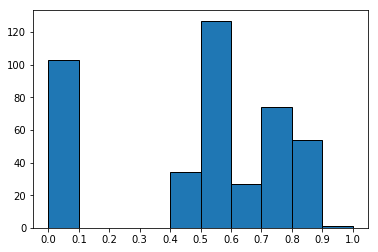

In [21]:
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x1a28ebbcf8>,
 <a list of 11 Text xticklabel objects>)

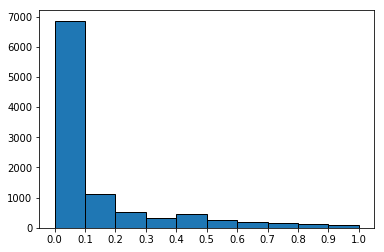

In [22]:
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [23]:
len(avg_list)

12949

In [24]:
len(variance_list)

12949

## Intercluster Similarity

In [25]:
#def intercluster_similarity(index):

In [30]:
def calculate_centroid(index):
    cluster_centroid = BOW[index].toarray()
    for i in indices50[index][1:]:
        cluster_centroid = np.add(cluster_centroid, BOW[i].toarray())
    return cluster_centroid/len(indices50[index][1:])

In [31]:
index_centroid = dict()
for i in range(BOW.shape[0]):
    index_centroid[i] = calculate_centroid(i)

In [32]:
#centroid_centroid_distance = {}
#for i in range(BOW.shape[0]):
#    for j in range(BOW.shape[0]):
#        if i < j:
#            key = str(i) + "::" + str(j)
#            centroid_centroid_distance[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
#centroid_centroid_distance

## 10 documents sample

In [33]:
indices10sample = sample(range(BOW.shape[0]),10)

In [34]:
centroid_centroid_distance_10 = {}
for i in indices10sample:
    for j in indices10sample:
        if i < j:
            key = str(i) + "::" + str(j)
            centroid_centroid_distance_10[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
centroid_centroid_distance_10

{'1694::4980': 10.229560028450726,
 '1694::12210': 6.2968361716495975,
 '1694::3851': 11.187601723330458,
 '1694::8656': 6.256724828615041,
 '1694::6520': 6.163569393768794,
 '1694::11838': 6.55677158701711,
 '1694::11331': 15.270939154940205,
 '1694::9082': 6.022586945770641,
 '1694::11606': 8.403357057107465,
 '4980::12210': 9.431839702125838,
 '4980::8656': 9.288584440929892,
 '4980::6520': 9.335636157076252,
 '4980::11838': 9.571363299894932,
 '4980::11331': 16.067498709678055,
 '4980::9082': 9.70647945654001,
 '4980::11606': 10.63737213620834,
 '3851::4980': 12.86198483493938,
 '3851::12210': 8.69701485981752,
 '3851::8656': 9.42083789208376,
 '3851::6520': 9.418140709679479,
 '3851::11838': 9.526372347110591,
 '3851::11331': 13.158091057085583,
 '3851::9082': 9.864196571988453,
 '3851::11606': 10.68567608854899,
 '8656::12210': 1.472643784757425,
 '8656::11838': 2.5655098712780577,
 '8656::11331': 14.090414298157132,
 '8656::9082': 3.1917088548942965,
 '8656::11606': 6.1449586208

In [35]:
# 9, 6, 21, 10
np.array(list(centroid_centroid_distance_10.values())).mean()

8.340322013261089

## 100 documents samples

In [36]:
indices100sample = sample(range(BOW.shape[0]),100)

In [37]:
centroid_centroid_distance_100 = {}
for i in indices100sample:
    for j in indices100sample:
        if i < j:
            key = str(i) + "::" + str(j)
            centroid_centroid_distance_100[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
centroid_centroid_distance_100

{'11980::12540': 4.080612117315042,
 '11980::12500': 6.251863528927983,
 '11980::12293': 82.93511963660424,
 '11980::12759': 5.528201899644404,
 '11980::12559': 1.2472376808651038,
 '11980::12483': 3.4918838484876056,
 '11980::12867': 3.790043731526124,
 '11980::12685': 8.743653615657696,
 '11980::12757': 4.209526887677023,
 '4868::11980': 5.847179180868143,
 '4868::12540': 5.739340117956739,
 '4868::11224': 13.319309228861213,
 '4868::5896': 5.628177754802183,
 '4868::10242': 5.280826674143833,
 '4868::12500': 7.371161881857327,
 '4868::6360': 6.883089878878263,
 '4868::7028': 10.844860322686301,
 '4868::11253': 7.616812111300817,
 '4868::11259': 13.737604688976432,
 '4868::9532': 5.554695662084078,
 '4868::9531': 20.16588845202607,
 '4868::6131': 6.208175341130629,
 '4868::5825': 19.571928660802445,
 '4868::11314': 5.757670580389829,
 '4868::10413': 63.85916798792444,
 '4868::11785': 3.8423753586162634,
 '4868::10712': 14.107739774063552,
 '4868::8709': 4.094367887293649,
 '4868::827

In [38]:
# 12, 46, 15, 17, 20
np.array(list(centroid_centroid_distance_100.values())).mean()

19.521262315961156

## 200 documents sample

In [39]:
indices200sample = sample(range(BOW.shape[0]),200)

In [40]:
centroid_centroid_distance_200 = {}
for i in indices200sample:
    for j in indices200sample:
        if i < j:
            key = str(i) + "::" + str(j)
            centroid_centroid_distance_200[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
centroid_centroid_distance_200

{'10516::12549': 4.652971714140841,
 '10516::12783': 7.565622946080893,
 '10516::11043': 4.619328135110675,
 '10516::11430': 17.897819560575165,
 '10516::11587': 6.589087693659534,
 '10516::12803': 4.468502381785944,
 '10516::10805': 3.3277198325027033,
 '10516::11700': 4.46677773011997,
 '10516::12876': 4.47692961662007,
 '10516::12910': 12.424750593953554,
 '10516::10618': 5.307809778813038,
 '10516::12866': 7.61273730420321,
 '10516::11370': 4.462253181621698,
 '10516::12722': 4.553033324405228,
 '10516::12348': 6.173258556022112,
 '10516::10852': 9.98541210018373,
 '10516::11666': 16.358743731100148,
 '10516::11653': 17.99173765667745,
 '10516::12705': 20.24947487762728,
 '10516::11468': 4.812000824677095,
 '10516::11875': 4.485433873614562,
 '10516::10617': 4.965520432896506,
 '10516::12429': 4.768789968912118,
 '10516::12647': 4.479068817963355,
 '10516::10529': 4.379203817187527,
 '10516::12786': 23.906749982181548,
 '10516::12664': 7.219818621310007,
 '10516::11002': 13.0254292

In [41]:
# 23, 22, 25, 13, 19, 20
np.array(list(centroid_centroid_distance_200.values())).mean()

11.148732972099284

## 300 documents sample

In [42]:
indices300sample = sample(range(BOW.shape[0]),300)

In [43]:
centroid_centroid_distance_300 = {}
for i in indices300sample:
    for j in indices300sample:
        if i < j:
            key = str(i) + "::" + str(j)
            centroid_centroid_distance_300[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
centroid_centroid_distance_300

{'207::3896': 9.655067315386244,
 '207::1612': 14.917097017301105,
 '207::8363': 10.737603392466632,
 '207::6983': 10.297470605669899,
 '207::9820': 10.197998186592518,
 '207::2043': 10.706060983118896,
 '207::5005': 10.426094997311374,
 '207::12233': 10.954165993040368,
 '207::3213': 36.28202961021339,
 '207::12287': 13.55484639866108,
 '207::5810': 10.470362368607205,
 '207::4995': 10.700282394184057,
 '207::3162': 10.693702288640145,
 '207::7609': 10.425995128874844,
 '207::4981': 10.470163475259938,
 '207::9052': 11.271811194900952,
 '207::1355': 50.19305088706109,
 '207::12370': 9.235049040413493,
 '207::11701': 9.90988131135608,
 '207::7535': 15.469710836107108,
 '207::5043': 10.924945567453037,
 '207::8263': 10.68974838492989,
 '207::6859': 10.423458149773678,
 '207::3732': 19.350221455769915,
 '207::8652': 19.885888541845663,
 '207::6760': 9.76459703565068,
 '207::6441': 10.453164021839124,
 '207::9192': 10.248617098735068,
 '207::6376': 10.41724293838431,
 '207::7474': 10.7529

In [44]:
# 17, 19, 24, 17
np.array(list(centroid_centroid_distance_300.values())).mean()

18.19384216279913

## 400 documents sample

In [45]:
indices400sample = sample(range(BOW.shape[0]),400)

In [46]:
centroid_centroid_distance_400 = {}
for i in indices400sample:
    for j in indices400sample:
        if i < j:
            key = str(i) + "::" + str(j)
            centroid_centroid_distance_400[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
centroid_centroid_distance_400

{'7862::9913': 5.42561681141016,
 '7862::9928': 2.086928038545525,
 '7862::8796': 2.5705375845438807,
 '7862::11977': 2.8769720071681535,
 '7862::10404': 5.082288294725505,
 '7862::10273': 0.750399033095928,
 '7862::12906': 6.421635390060863,
 '7862::11818': 28.359123753064893,
 '7862::9560': 0.37297279352034823,
 '7862::7952': 3.126980838260576,
 '7862::11238': 2.0152479970951265,
 '7862::10420': 0.8583567691760445,
 '7862::8095': 14.256456920697202,
 '7862::11550': 0.7128264978193054,
 '7862::8686': 3.152119930825767,
 '7862::12211': 11.690493508999738,
 '7862::10552': 0.9878478620637507,
 '7862::12321': 4.678501880060819,
 '7862::9974': 7.872658944122943,
 '7862::8445': 3.143387180324923,
 '7862::9043': 4.014758280184898,
 '7862::8545': 0.6817670648363292,
 '7862::9219': 2.629962238213188,
 '7862::10565': 0.8485968525017058,
 '7862::10199': 0.39043115244304055,
 '7862::9422': 2.703600265202402,
 '7862::10738': 0.38775510204081626,
 '7862::12930': 0.9487052489117924,
 '7862::10156': 

In [47]:
# 22, 16, 17, 17
np.array(list(centroid_centroid_distance_400.values())).mean()

17.86915226869117

## 500 documents sample

In [48]:
indices500sample = sample(range(BOW.shape[0]),500)

In [49]:
centroid_centroid_distance_500 = {}
for i in indices500sample:
    for j in indices500sample:
        if i < j:
            key = str(i) + "::" + str(j)
            centroid_centroid_distance_500[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
centroid_centroid_distance_500

{'6400::8965': 10.12388896933339,
 '6400::11275': 44.15613036030787,
 '6400::8211': 9.839549940100927,
 '6400::9751': 10.176738876514735,
 '6400::9102': 10.803091633323499,
 '6400::10245': 112.30620218282557,
 '6400::6619': 10.086279190317885,
 '6400::8528': 10.161707937394906,
 '6400::9984': 10.054764660506768,
 '6400::11753': 23.472404420144244,
 '6400::11604': 9.900483582987732,
 '6400::9160': 10.447225618094434,
 '6400::8267': 9.757663398687336,
 '6400::8702': 9.87852078221472,
 '6400::12653': 9.826588890835302,
 '6400::8384': 10.701060837150674,
 '6400::11609': 9.905530451606156,
 '6400::7791': 16.1530708935472,
 '6400::8711': 10.518542363103274,
 '6400::12418': 9.905635567359429,
 '6400::6636': 9.894087187110246,
 '6400::7584': 9.828983312272756,
 '6400::7793': 10.783933009900231,
 '6400::11513': 10.236418150884946,
 '6400::7966': 9.899537008681556,
 '6400::9606': 20.15653031366545,
 '6400::12542': 10.030793902895509,
 '6400::12530': 9.870359162875733,
 '6400::10144': 10.21721603

In [50]:
# 15, 19, 17, 22, 18, 17
np.array(list(centroid_centroid_distance_500.values())).mean()

18.98599553198772